In [ ]:
#!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!kaggle competitions download global-wheat-detection
#!unzip global-wheat-detection.zip

In [ ]:
#!git clone https://github.com/facebookresearch/detr.git  #cloner le repo github de detr pour importer sa perte unique

In [ ]:
# ! pip install --upgrade albumentations

In [ ]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS########################
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

<ipython-input-5-d875a0c87f69>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
num_classes = 2
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 8
LR = 2e-5
EPOCHS = 2

# Préparation des données


In [ ]:
df = pd.read_csv('train.csv')
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [ ]:


bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)

(-0.5, 1023.5, 1023.5, -0.5)

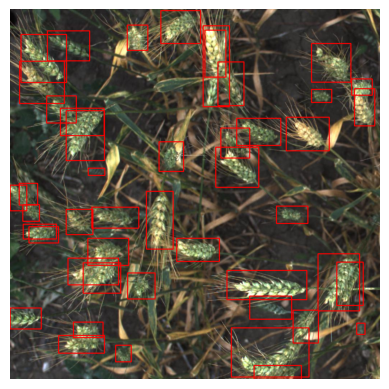

In [ ]:
image_id = "b6ab77fd7"
records = df[df['image_id'] == image_id]

image = cv2.imread(f'train/{image_id}.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# DETR takes in data in coco format
boxes = records[['x', 'y', 'w', 'h']].values.astype('uint32')

for box in boxes:
        color = (255,0,0)
        cv2.rectangle(image,(box[0], box[1]), (box[2]+box[0], box[3]+box[1]),color, 2)


plt.imshow(image)
plt.axis('off')

In [ ]:
from sklearn.model_selection import train_test_split
train_index,valid_index=train_test_split(np.unique(df.image_id.values), test_size=0.2)

In [ ]:
DIR_TRAIN = 'train'

class WheatDataset(Dataset):
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms


    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        # DETR takes in data in coco format
        boxes = records[['x', 'y', 'w', 'h']].values

        #Area of bb
        area = boxes[:,2]*boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)

        # AS pointed out by PRVI It works better if the main class is labelled as zero
        labels =  np.zeros(len(boxes), dtype=np.int32)


        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']


        #Normalizing BBOXES

        _,h,w = image.shape
        boxes = A.core.bbox_utils.denormalize_bboxes(sample['bboxes'],rows=h,cols=w)
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area

        return image, target, image_id

In [ ]:
def get_train_transforms():
    return A.Compose([A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),

                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],p=0.9),

                      A.ToGray(p=0.01),

                      A.HorizontalFlip(p=0.5),

                      A.VerticalFlip(p=0.5),

                      A.Resize(height=512, width=512, p=1),

                      A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),

                      ToTensorV2(p=1.0)],

                      p=1.0,

                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

def get_valid_transforms():
    return A.Compose([A.Resize(height=512, width=512, p=1.0),
                      ToTensorV2(p=1.0)],
                      p=1.0,
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

In [ ]:
train_dataset = WheatDataset(
    image_ids=train_index,
    dataframe=df,
    transforms=get_train_transforms()
    )

valid_dataset = WheatDataset(
    image_ids=valid_index,
    dataframe=df,
    transforms=get_valid_transforms()
    )

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
    )
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
    )


# Modèle

* Le modèle DETR initial est entraîné sur le jeu de données coco, qui comporte 91 classes + 1 classe d'arrière-plan, nous devons donc le modifier pour prendre notre propre nombre de classes.
* Le modèle DETR prend également en compte 100 requêtes, c'est à dire qu'il produit un total de 100 bboxes pour chaque image, nous pouvons très bien changer cela aussi.

In [ ]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries

        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features

        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries

    def forward(self,images):
        return self.model(images)

# Matcher and Bipartite Matching Loss

# L'apparieur et la perte d'appariement bipartite

Nous allons maintenant utiliser la perte unique que le modèle utilise et, pour cela, nous devons définir l'agent d'appariement. DETR calcule trois pertes individuelles :
* Perte de classification pour les étiquettes (son poids peut être défini par loss_ce)
* Perte pour la boîte (son poids peut être défini par loss_bbox)
* Perte pour la classe d'arrière-plan

In [ ]:

matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()

    summary_loss = AverageMeter()

    tk0 = tqdm(data_loader, total=len(data_loader))

    for step, (images, targets, image_ids) in enumerate(tk0):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


        output = model(images) # B, 100,4 + 1

        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict

        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)

    return summary_loss

In [ ]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()

    with torch.no_grad():

        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)

            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict

            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)

    return summary_loss

In [ ]:
device = torch.device('cuda')
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model = model.to(device)
criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

best_loss = np.inf
for epoch in range(EPOCHS):
        train_loss = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_loss = eval_fn(valid_data_loader, model,criterion, device)

        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            print('Best model found in Epoch {}........Saving Model'.format(epoch+1))
            torch.save(model.state_dict(), 'detr_best.pth')

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/14780 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
!kaggle kernels output tanulsingh077/end-to-end-object-detection-with-transformers-detr

Output file downloaded to /content/detr/.circleci/config.yml
Output file downloaded to /content/detr/.git/HEAD
Output file downloaded to /content/detr/.git/config
Output file downloaded to /content/detr/.git/description
Output file downloaded to /content/detr/.git/hooks/applypatch-msg.sample
Output file downloaded to /content/detr/.git/hooks/commit-msg.sample
Output file downloaded to /content/detr/.git/hooks/fsmonitor-watchman.sample
Output file downloaded to /content/detr/.git/hooks/post-update.sample
Output file downloaded to /content/detr/.git/hooks/pre-applypatch.sample
Output file downloaded to /content/detr/.git/hooks/pre-commit.sample
Output file downloaded to /content/detr/.git/hooks/pre-push.sample
Output file downloaded to /content/detr/.git/hooks/pre-rebase.sample
Output file downloaded to /content/detr/.git/hooks/pre-receive.sample
Output file downloaded to /content/detr/.git/hooks/prepare-commit-msg.sample
Output file downloaded to /content/detr/.git/hooks/update.sample
O

# Inférence de modèle sur des échantillons

<All keys matched successfully>

In [ ]:
def view_sample(valid_data_loader,model,device):
    '''
    Code taken from Peter's Kernel
    https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    '''

    images, targets, image_ids = next(iter(valid_data_loader))
    _,h,w = images[0].shape # for de normalizing images

    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    boxes = targets[0]['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in A.core.bbox_utils.denormalize_bboxes (boxes,h,w)]
    sample = images[0].permute(1,2,0).cpu().numpy()

    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")

    with torch.no_grad():
        outputs = model(images)

    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 1)


    oboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.core.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    prob   = outputs[0]['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]

    for box,p in zip(oboxes,prob):

        if p >0.5:
            color = (255,0,0)
            cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  color, 1)

    ax.set_axis_off()
    ax.imshow(sample)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


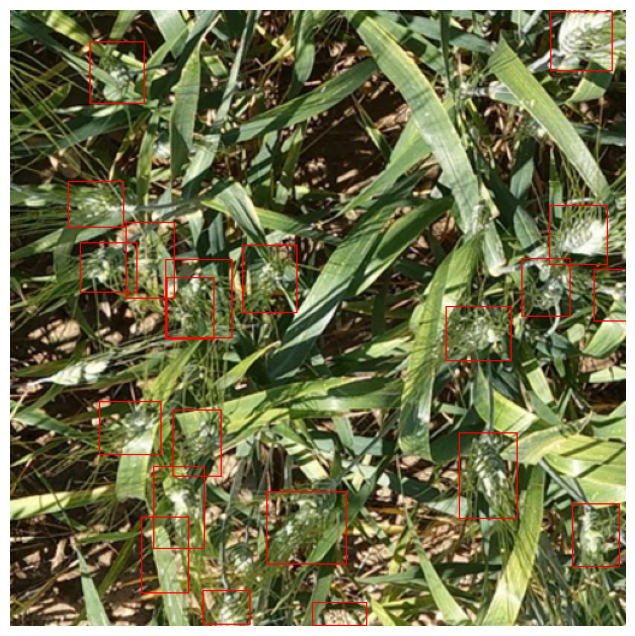

In [ ]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)

model.load_state_dict(torch.load('detr_best_0.pth'))
view_sample(valid_data_loader,model=model,device=torch.device('cuda'))